# Query Performance Comparison Between Multiple Methods

This notebook compares query performance between different methods or approaches. You can use this to evaluate the performance differences between:
- Different databases (e.g., InfluxDB vs PostgreSQL vs MongoDB)
- Different query optimization techniques
- Various caching mechanisms
- Different cache invalidation strategies
- Custom indexing approaches

The notebook makes it easy to:
1. Load results from multiple experiment files
2. Label the methods for clear comparison
3. Visualize performance differences
4. Perform statistical analysis of the differences

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [12, 8]
outFolder = "output"
# Define the methods you want to compare
# For each method, provide a name and the corresponding path to results
METHODS = [
    {
        "name": "Standard Queries",
        "path": f"../{outFolder}/timeQueries/",
        "database": "influx",
        "table": "intel_lab_exp"
    },
    {
        "name": "Cached Queries (M4)",
        "path": f"../{outFolder}/timeCacheQueries/",
        "database": "influx", 
        "table": "intel_lab_exp"
    },
    # {
    #     "name": "Cached Queries (MinMax)",
    #     "path": f"../{outFolder}/timeCacheQueriesM2/",
    #     "database": "influx", 
    #     "table": "intel_lab_exp"
    # },
]

# Generate a color palette with enough colors for all methods
METHOD_COLORS = sns.color_palette("hls", len(METHODS))

## Load Query Results Data

First, let's define the function to load experiment results from CSV files.

In [2]:
def load_results(base_path="../output/timeQueries/", 
                database_type="influx", 
                table_name="intel_lab_exp", 
                run_pattern="run_*"):
    """
    Load results from multiple experiment runs into a single dataframe
    
    Parameters:
    -----------
    base_path : str
        Base path to the timeQueries directory
    database_type : str
        Type of database (influx, postgres, etc.)
    table_name : str
        Name of the database table
    run_pattern : str
        Pattern to match run folders
        
    Returns:
    --------
    pd.DataFrame: Combined results from all runs
    """
    # Create path pattern
    path_pattern = os.path.join(base_path, database_type, table_name, run_pattern, "results.csv")
    
    # Find all matching CSV files
    csv_files = glob.glob(path_pattern)
    
    if not csv_files:
        print(f"No results found matching pattern: {path_pattern}")
        return None
    
    # Load and combine all CSV files
    dfs = []
    for csv_file in csv_files:
        run_name = os.path.basename(os.path.dirname(csv_file))
        df = pd.read_csv(csv_file)
        df['run'] = run_name
        dfs.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(csv_files)} result files with a total of {len(combined_df)} queries")
    
    # Convert date columns to datetime if they exist
    date_columns = ['from', 'to']
    for col in date_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
            
    # Add duration column
    if 'from' in combined_df.columns and 'to' in combined_df.columns:
        combined_df['duration_sec'] = (combined_df['to'] - combined_df['from']).dt.total_seconds()
    
    return combined_df

# Define a mapping for operation type labels (for better readability)
def get_operation_type_mapping():
    return {
        'P': 'Pan',
        'ZI': 'Zoom In',
        'ZO': 'Zoom Out',
        'R': 'Resize',
        'MC': 'Measure Change',
        'PD': 'Pattern Detection',
        'NaN': 'Initial Query'
    }

## Load Data from All Methods

Now let's load the data from all methods we want to compare.

In [3]:
# Load data for each method
method_results = []
method_dfs = []

for i, method in enumerate(METHODS):
    print(f"\nLoading data for {method['name']}:")
    
    # Load data for this method
    df = load_results(
        base_path=method['path'],
        database_type=method['database'],
        table_name=method['table']
    )
    
    if df is not None:
        # Add method name and color index
        df['method'] = method['name']
        df['method_idx'] = i
        
        # Add readable operation type
        op_type_map = get_operation_type_mapping()
        df['operation'] = df.apply(
            lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
            axis=1
        )
        
        print(f"Operation types: {df['operation'].unique()}")
        print(f"Total queries: {len(df)}")
        
        method_dfs.append(df)
        method_results.append({
            "name": method['name'],
            "data": df,
            "color": METHOD_COLORS[i]
        })
    else:
        print(f"WARNING: Could not load data for {method['name']}")

# Combine datasets for comparison if we have at least one method
if len(method_dfs) > 0:
    combined_results = pd.concat(method_dfs, ignore_index=True)
    print(f"\nCombined dataset with {len(combined_results)} total queries from {len(method_dfs)} methods")
    display(combined_results[['method', 'query #', 'operation', 'Time (sec)']].head(10))
else:
    combined_results = None
    print("\nWarning: No datasets could be loaded.")
    
# Get a list of all method names that were successfully loaded
method_names = [method['name'] for method in method_results]
print(f"\nMethods available for comparison: {method_names}")


Loading data for Standard Queries:


EmptyDataError: No columns to parse from file

## Basic Performance Comparison

Let's start with some basic performance comparisons between all methods.

Overall Performance Summary:


,count,mean,std,min,max,median
method,,,,,,
Cached Queries (M4),51,0.218708,0.366798,0.008262,1.813125,0.030993
Standard Queries,51,0.999442,0.341807,0.218942,1.647157,1.025854


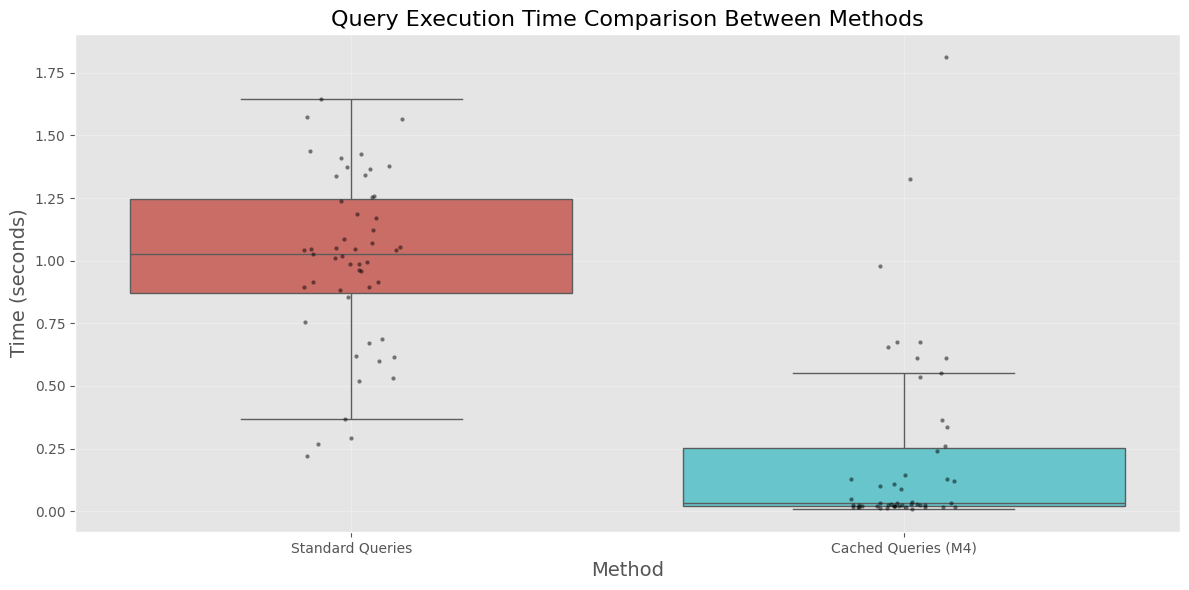


Performance comparison (baseline: Standard Queries):
Cached Queries (M4) vs Standard Queries: 78.12% (faster by 78.12%)
  Statistical significance: p-value = 0.0000
  The performance difference is statistically significant


In [ ]:
if combined_results is not None and len(method_names) > 1:
    # Overall performance comparison
    print("Overall Performance Summary:")
    performance_summary = combined_results.groupby('method')['Time (sec)'].agg(['count', 'mean', 'std', 'min', 'max', 'median'])
    display(performance_summary)
    
    # Create a comparative boxplot
    plt.figure(figsize=(max(12, len(method_names) * 3), 6))
    sns.boxplot(x='method', y='Time (sec)', data=combined_results, 
                palette={m['name']: m['color'] for m in method_results},
                showfliers=False)
    sns.stripplot(x='method', y='Time (sec)', data=combined_results, 
                 color='black', size=3, alpha=0.5)
    plt.title('Query Execution Time Comparison Between Methods', fontsize=16)
    plt.xlabel('Method', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45 if len(method_names) > 2 else 0)
    plt.tight_layout()
    plt.show()
    
    # Calculate improvement percentages (using the first method as baseline)
    if len(method_names) >= 2:
        baseline_method = method_names[0]
        baseline_avg = performance_summary.loc[baseline_method, 'mean']
        
        print(f"\nPerformance comparison (baseline: {baseline_method}):")
        
        for method_name in method_names[1:]:
            if method_name in performance_summary.index:
                method_avg = performance_summary.loc[method_name, 'mean']
                improvement_pct = ((baseline_avg - method_avg) / baseline_avg) * 100
                
                print(f"{method_name} vs {baseline_method}: {improvement_pct:.2f}% " + 
                     f"({'faster' if improvement_pct > 0 else 'slower'} by {abs(improvement_pct):.2f}%)")
                
                # Statistical test to determine if the difference is significant
                t_stat, p_value = stats.ttest_ind(
                    combined_results[combined_results['method'] == baseline_method]['Time (sec)'],
                    combined_results[combined_results['method'] == method_name]['Time (sec)']
                )
                
                print(f"  Statistical significance: p-value = {p_value:.4f}")
                print(f"  The performance difference is {'statistically significant' if p_value < 0.05 else 'not statistically significant'}")
        
        # All pairwise comparisons
        if len(method_names) > 2:
            print("\nAll pairwise comparisons:")
            for i, method_i in enumerate(method_names):
                for j, method_j in enumerate(method_names):
                    if i < j:  # To avoid duplicate comparisons
                        method_i_avg = performance_summary.loc[method_i, 'mean']
                        method_j_avg = performance_summary.loc[method_j, 'mean']
                        diff_pct = ((method_i_avg - method_j_avg) / method_i_avg) * 100
                        
                        print(f"{method_j} vs {method_i}: {diff_pct:.2f}% " + 
                             f"({'faster' if diff_pct > 0 else 'slower'} by {abs(diff_pct):.2f}%)")
    else:
        print("Need at least 2 methods to compare performance.")
else:
    print("Cannot perform comparison analysis without multiple datasets.")

## Performance Comparison by Operation Type

Let's break down the performance by the type of operation.

Performance by Operation Type:


count                                 mean  \
method            Cached Queries (M4) Standard Queries Cached Queries (M4)   
operation                                                                    
Initial Query                       1                1            1.813125   
Measure Change                      3                3            0.414628   
Pan                                21               21            0.156220   
Pattern Detection                  10               10            0.257286   
Zoom In                             8                8            0.185347   
Zoom Out                            8                8            0.095104   

                                                median                   
method            Standard Queries Cached Queries (M4) Standard Queries  
operation                                                                
Initial Query             1.171222            1.813125         1.171222  
Measure Change            1.140347            0.553134         1.046886  
Pan                       1.141745            0.030993         1.044213  
Pattern Detection         0.586282            0.018983         0.525014  
Zoom In                   0.964124            0.027915         0.888967  
Zoom Out                  1.103350            0.099243         1.059358

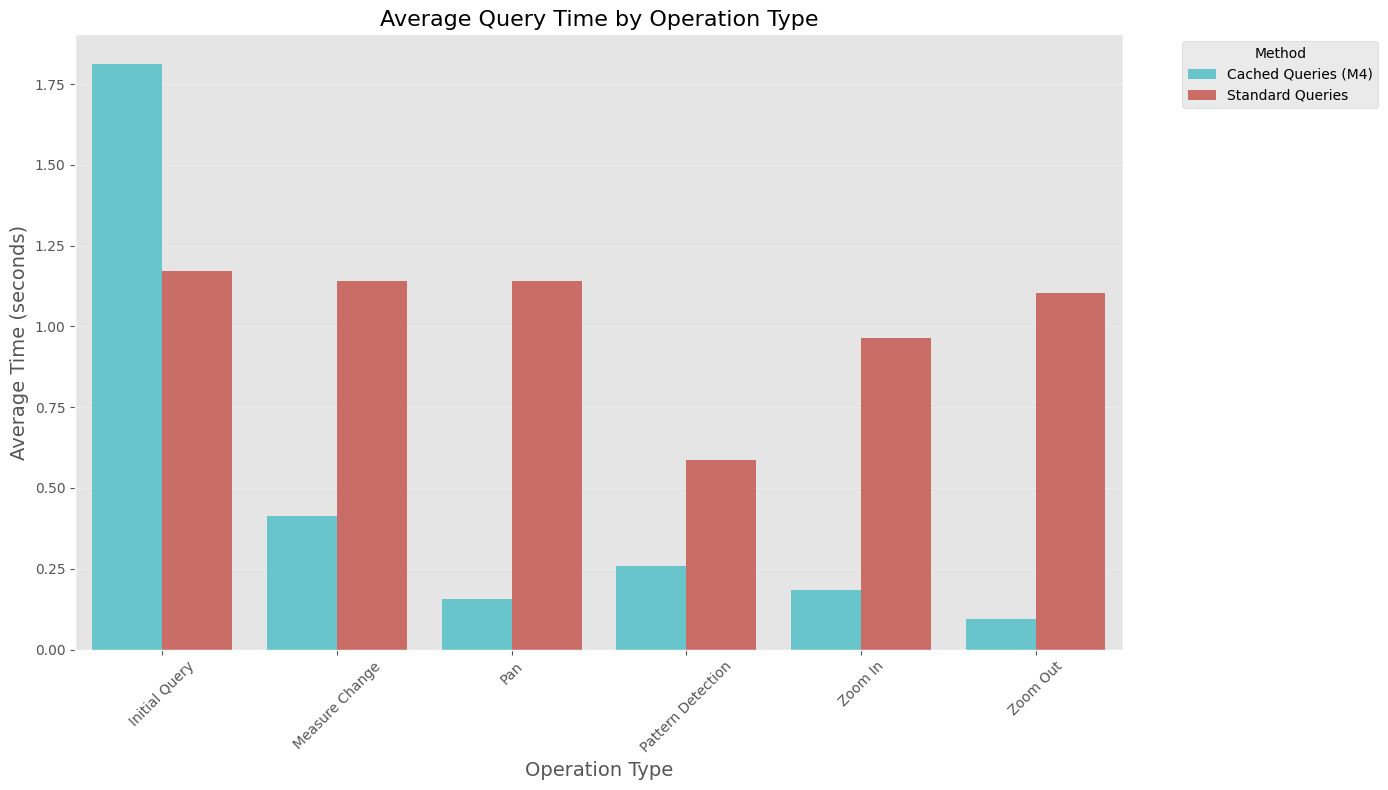


Performance Improvement by Operation Type (baseline: Standard Queries):

Initial Query operations:

Measure Change operations:

Pan operations:

Pattern Detection operations:

Zoom In operations:

Zoom Out operations:


In [ ]:
if combined_results is not None and len(method_names) > 1:
    # Calculate average query time by operation type for each method
    op_performance = combined_results.pivot_table(
        index='operation', 
        columns='method', 
        values='Time (sec)',
        aggfunc=['count', 'mean', 'median']
    )
    
    print("Performance by Operation Type:")
    display(op_performance)
    
    # Plot comparison by operation type
    plt.figure(figsize=(max(14, len(method_names) * 3), 8))
    
    # Convert to a format suitable for plotting
    op_perf_plot = combined_results.groupby(['method', 'operation'])['Time (sec)'].mean().reset_index()
    
    # Create the grouped bar chart
    sns.barplot(x='operation', y='Time (sec)', hue='method', data=op_perf_plot,
               palette={m['name']: m['color'] for m in method_results})
    
    plt.title('Average Query Time by Operation Type', fontsize=16)
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Average Time (seconds)', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate performance improvement for each operation type
    if op_performance.columns.nlevels > 1 and len(method_names) >= 2:
        baseline_method = method_names[0]
        print(f"\nPerformance Improvement by Operation Type (baseline: {baseline_method}):")
        
        for op in op_performance.index:
            try:
                baseline_time = op_performance.loc[op, ('mean', baseline_method)]
                baseline_count = op_performance.loc[op, ('count', baseline_method)]
                
                print(f"\n{op} operations:")
                for method_name in method_names[1:]:
                    if (method_name in op_performance.columns[1] and 
                        not pd.isna(op_performance.loc[op, ('mean', method_name)])):
                        
                        method_time = op_performance.loc[op, ('mean', method_name)]
                        method_count = op_performance.loc[op, ('count', method_name)]
                        imp_pct = ((baseline_time - method_time) / baseline_time) * 100
                        
                        print(f"  {method_name}: {imp_pct:.2f}% {'improvement' if imp_pct > 0 else 'regression'} " +
                              f"({baseline_time:.4f}s → {method_time:.4f}s, n={baseline_count}/{method_count})")
            except:
                print(f"{op}: Insufficient data for comparison")
else:
    print("Cannot perform operation type analysis without multiple datasets.")

## Query Execution Time Distribution

Let's compare the distribution of query execution times between the different methods.

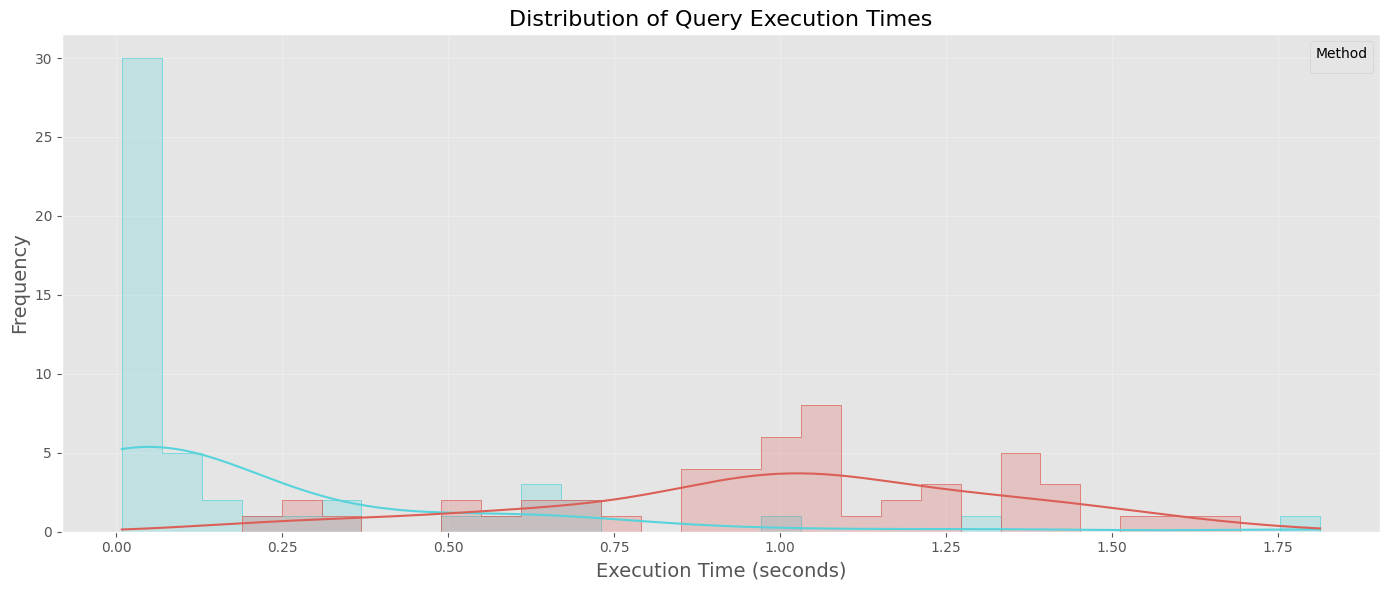

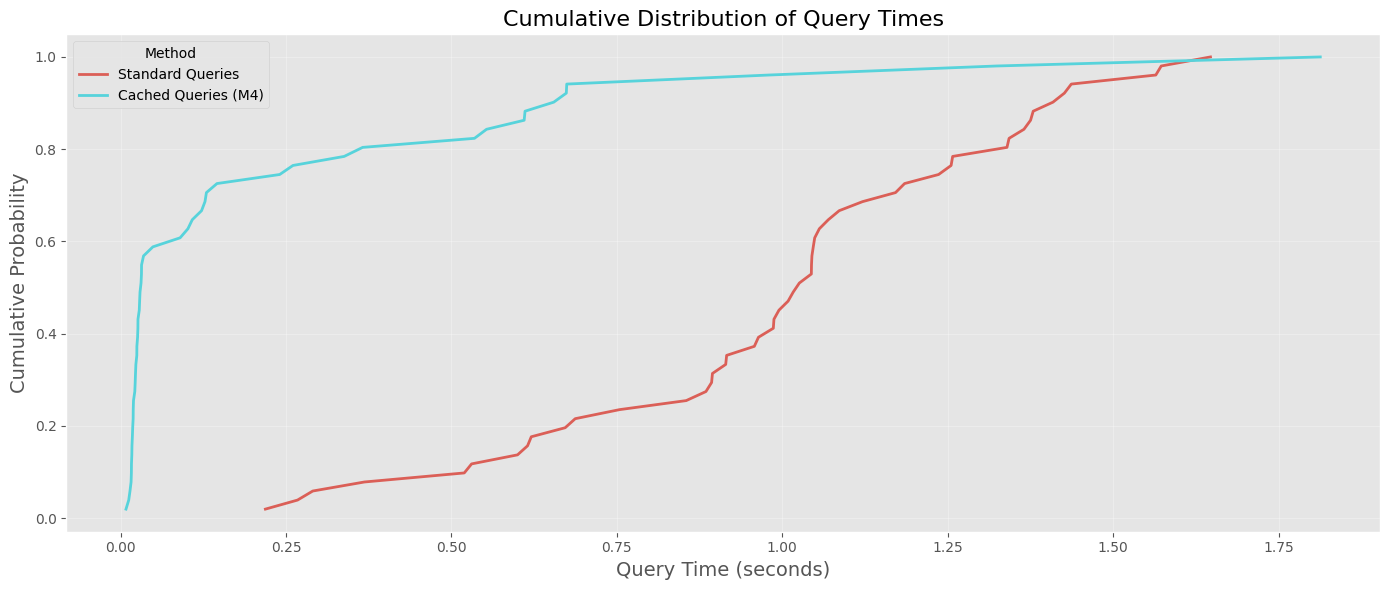

Query Time Percentiles by Method:


,50th,75th,90th,95th,99th
method,,,,,
Cached Queries (M4),0.030993,0.250569,0.654714,0.826981,1.568548
Standard Queries,1.025854,1.245760,1.409143,1.500706,1.609962


In [ ]:
if combined_results is not None and len(method_names) > 1:
    # Plot the distribution of query times
    plt.figure(figsize=(14, 6))
    sns.histplot(data=combined_results, x='Time (sec)', hue='method', bins=30, 
                 kde=True, element='step', common_norm=False, 
                 palette={m['name']: m['color'] for m in method_results})
    plt.title('Distribution of Query Execution Times', fontsize=16)
    plt.xlabel('Execution Time (seconds)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()
    
    # Create a cumulative distribution plot
    plt.figure(figsize=(14, 6))
    for m in method_results:
        method = m['name']
        color = m['color']
        subset = combined_results[combined_results['method'] == method]
        sorted_times = np.sort(subset['Time (sec)'])
        cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
        plt.plot(sorted_times, cumulative, label=method, linewidth=2, color=color)
        
    plt.title('Cumulative Distribution of Query Times', fontsize=16)
    plt.xlabel('Query Time (seconds)', fontsize=14)
    plt.ylabel('Cumulative Probability', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()
    
    # Calculate percentile metrics
    percentiles = [50, 75, 90, 95, 99]
    percentile_stats = combined_results.groupby('method')['Time (sec)'].quantile(np.array(percentiles)/100).unstack()
    percentile_stats.columns = [f'{p}th' for p in percentiles]
    
    print("Query Time Percentiles by Method:")
    display(percentile_stats)
else:
    print("Cannot analyze query time distribution without multiple datasets.")

## Performance Consistency Analysis

Let's analyze how consistent each method is in terms of query performance.

Performance Consistency by Operation Type (lower CV means more consistent):


,method,operation,mean,std,cv
5,Cached Queries (M4),Zoom Out,0.095104,0.074520,0.783559
1,Cached Queries (M4),Measure Change,0.414628,0.350161,0.844519
2,Cached Queries (M4),Pan,0.156220,0.208748,1.336243
4,Cached Queries (M4),Zoom In,0.185347,0.295626,1.594986
3,Cached Queries (M4),Pattern Detection,0.257286,0.480084,1.865952
0,Cached Queries (M4),Initial Query,1.813125,NaN,NaN
7,Standard Queries,Measure Change,1.140347,0.195736,0.171646
11,Standard Queries,Zoom Out,1.103350,0.220578,0.199917
8,Standard Queries,Pan,1.141745,0.272333,0.238523
10,Standard Queries,Zoom In,0.964124,0.285818,0.296454


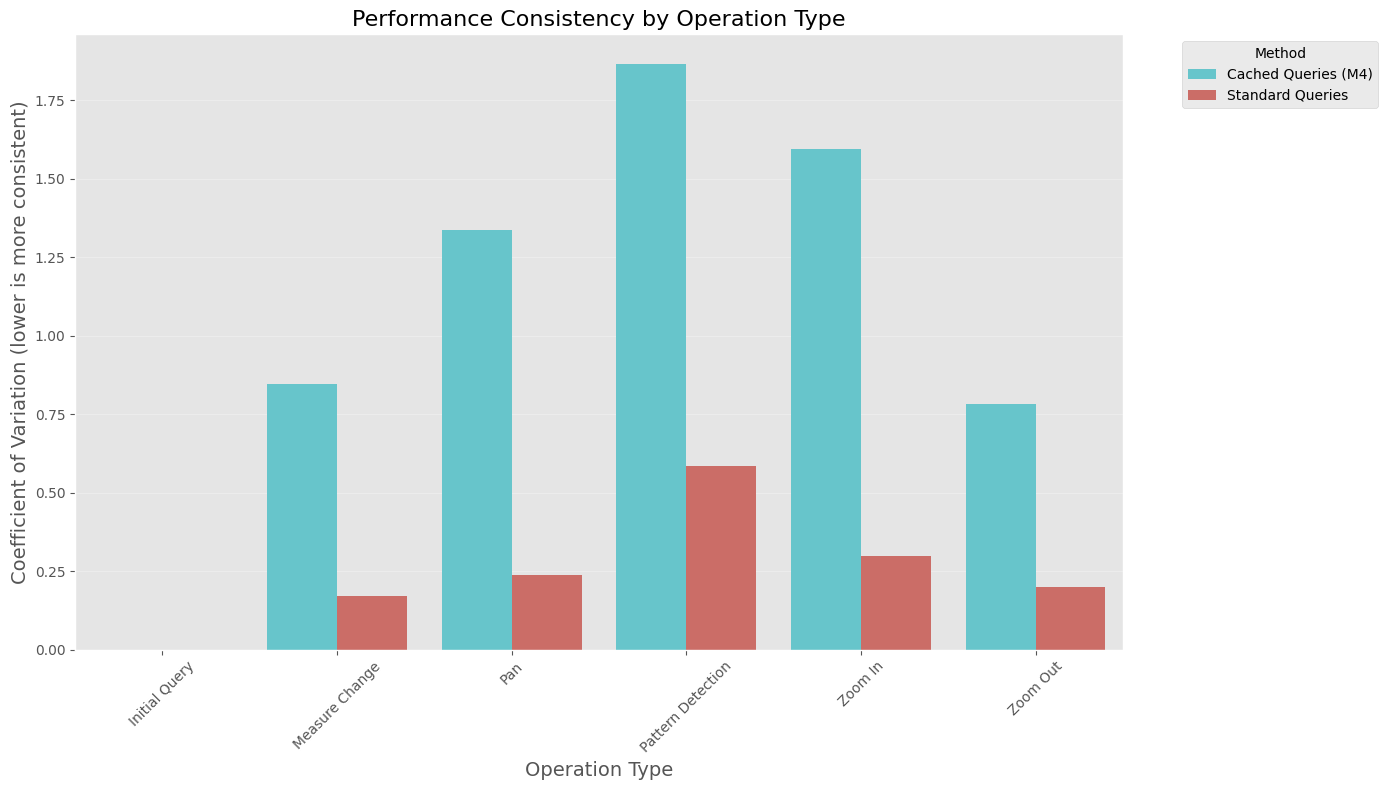

In [ ]:
if combined_results is not None and len(method_names) > 1:
    # Calculate coefficient of variation (CV) as a measure of consistency
    consistency_metrics = combined_results.groupby(['method', 'operation'])['Time (sec)'].agg([
        'mean', 
        'std', 
        ('cv', lambda x: x.std() / x.mean() if x.mean() > 0 else 0)  # CV = std/mean
    ]).reset_index()
    
    # Display consistency metrics
    print("Performance Consistency by Operation Type (lower CV means more consistent):")
    display(consistency_metrics.sort_values(['method', 'cv']))
    
    # Visualize consistency metrics
    plt.figure(figsize=(14, 8))
    
    # Plot CV bars by operation type and method
    sns.barplot(x='operation', y='cv', hue='method', data=consistency_metrics,
               palette={m['name']: m['color'] for m in method_results})
    
    plt.title('Performance Consistency by Operation Type', fontsize=16)
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Coefficient of Variation (lower is more consistent)', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot analyze performance consistency without multiple datasets.")

## Query Time Evolution Analysis

Let's see how query times evolve through the sequence of operations for all methods.

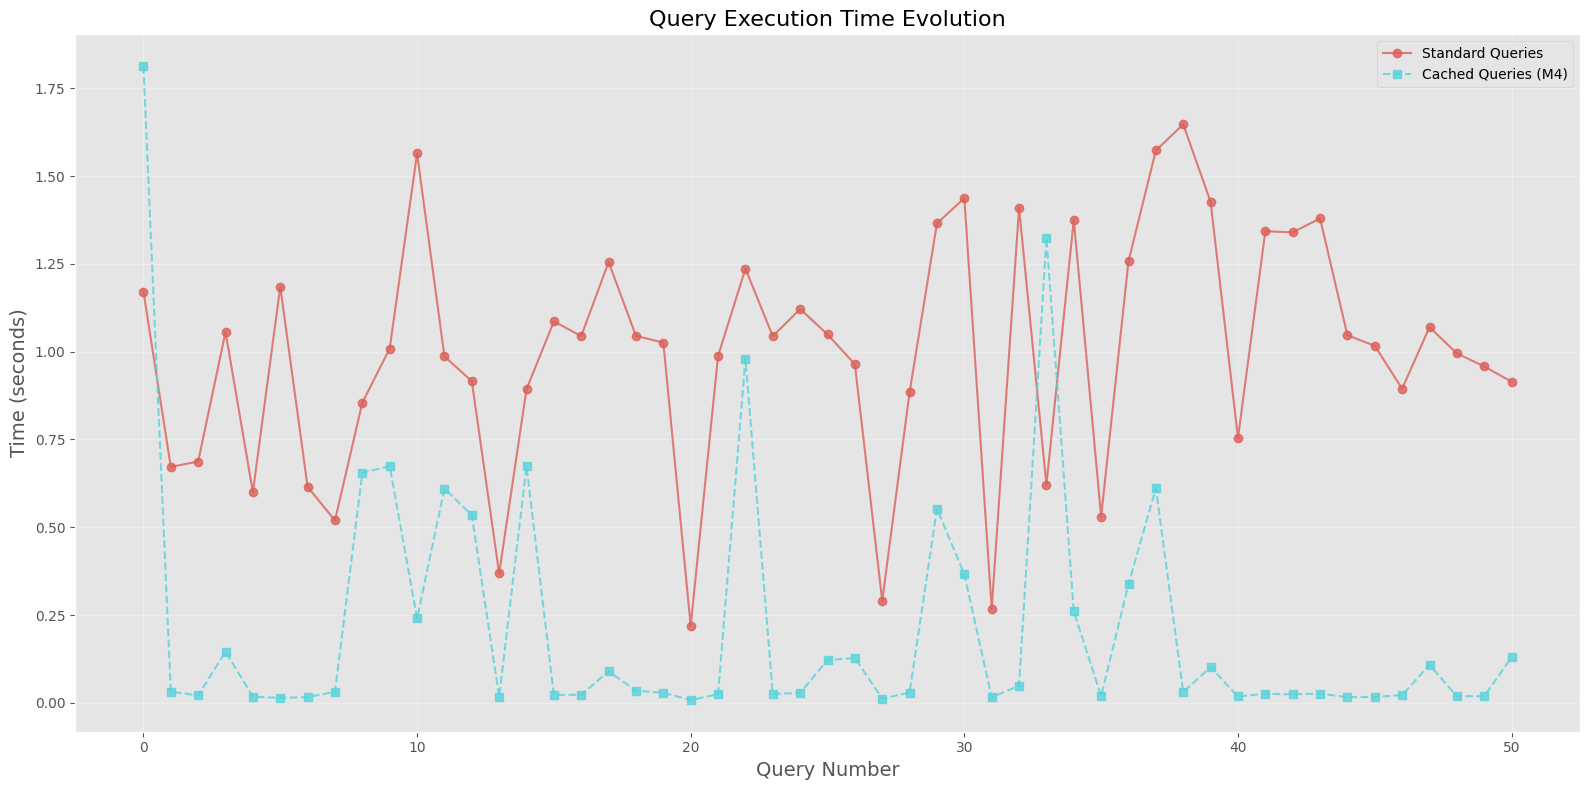

<Figure size 2000x1000 with 0 Axes>

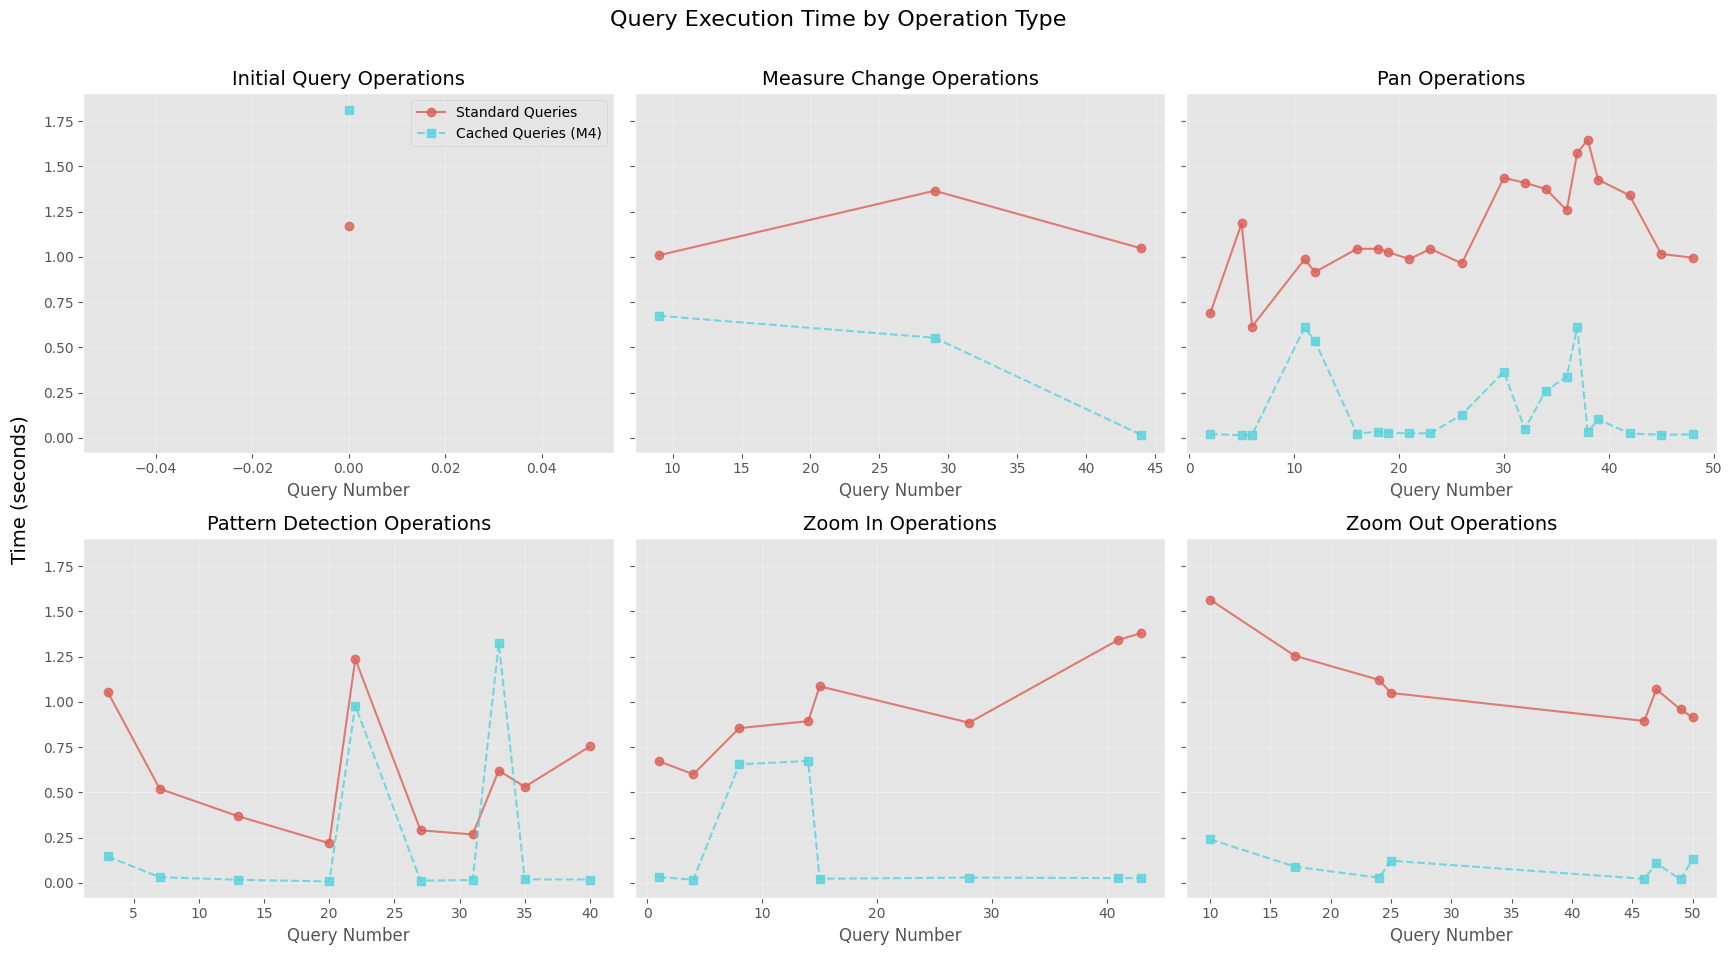

In [ ]:
if combined_results is not None and len(method_names) > 1:
    # Plot time series of query execution times
    plt.figure(figsize=(16, 8))
    
    # Different line styles for better distinction between methods
    line_styles = ['-', '--', ':', '-.'] * (len(method_names) // 4 + 1)
    markers = ['o', 's', 'D', '^', 'v', '<', '>'] * (len(method_names) // 7 + 1)
    
    for i, m in enumerate(method_results):
        method = m['name']
        color = m['color']
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        
        subset = combined_results[combined_results['method'] == method]
        
        if len(subset) > 0:
            # Sort by query number to ensure correct sequence
            subset = subset.sort_values('query #')
            plt.plot(subset['query #'], subset['Time (sec)'], 
                    label=method, linestyle=linestyle, marker=marker, 
                    markersize=6, alpha=0.8, color=color)
    
    plt.title('Query Execution Time Evolution', fontsize=16)
    plt.xlabel('Query Number', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot time series by operation type
    plt.figure(figsize=(20, 10))
    
    # Create subplots for each operation type
    operation_types = sorted(combined_results['operation'].unique())
    n_ops = len(operation_types)
    
    # Calculate subplot grid dimensions
    n_cols = min(3, n_ops)
    n_rows = (n_ops + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows), sharey=True)
    
    # Flatten axes for easier indexing
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each operation type in a separate subplot
    for i, op_type in enumerate(operation_types):
        ax = axes[i]
        for j, m in enumerate(method_results):
            method = m['name']
            color = m['color']
            linestyle = line_styles[j % len(line_styles)]
            marker = markers[j % len(markers)]
            
            subset = combined_results[(combined_results['method'] == method) & 
                                     (combined_results['operation'] == op_type)]
            
            if len(subset) > 0:
                subset = subset.sort_values('query #')
                ax.plot(subset['query #'], subset['Time (sec)'], 
                        label=method, linestyle=linestyle, marker=marker, 
                        markersize=6, alpha=0.8, color=color)
                
        ax.set_title(f'{op_type} Operations', fontsize=14)
        ax.set_xlabel('Query Number', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first subplot
        if i == 0:
            ax.legend()
            
    # Add a common y-label
    fig.text(0.04, 0.5, 'Time (seconds)', va='center', rotation='vertical', fontsize=14)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Query Execution Time by Operation Type', fontsize=16)
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.97])
    plt.show()
else:
    print("Cannot analyze query time evolution without multiple datasets.")

## Statistical Analysis of Performance Differences

Now let's perform more detailed statistical analysis of the performance differences.


Statistical comparison by operation type:
Statistical comparison of methods by operation:
Skipping Initial Query: Not enough methods with data
  Pairwise comparisons for Zoom In:
    Cached Queries (M4) vs Standard Queries: 80.78% (improvement), p=0.0001 (significant)
  Pairwise comparisons for Pan:
    Cached Queries (M4) vs Standard Queries: 86.32% (improvement), p=0.0000 (significant)
  Pairwise comparisons for Pattern Detection:
    Cached Queries (M4) vs Standard Queries: 56.12% (improvement), p=0.0963 (not significant)
  Pairwise comparisons for Measure Change:
    Cached Queries (M4) vs Standard Queries: 63.64% (improvement), p=0.0488 (significant)
  Pairwise comparisons for Zoom Out:
    Cached Queries (M4) vs Standard Queries: 91.38% (improvement), p=0.0000 (significant)


,Group,Method1,Method2,Mean1,Mean2,Count1,Count2,Difference,Improvement %,p-value,Significant
3,Measure Change,Standard Queries,Cached Queries (M4),1.140347,0.414628,3,3,0.725720,63.640229,4.884311e-02,Yes
1,Pan,Standard Queries,Cached Queries (M4),1.141745,0.156220,21,21,0.985524,86.317412,1.262580e-15,Yes
2,Pattern Detection,Standard Queries,Cached Queries (M4),0.586282,0.257286,10,10,0.328996,56.115648,9.627875e-02,No
0,Zoom In,Standard Queries,Cached Queries (M4),0.964124,0.185347,8,8,0.778777,80.775589,1.016021e-04,Yes
4,Zoom Out,Standard Queries,Cached Queries (M4),1.103350,0.095104,8,8,1.008246,91.380410,9.973285e-07,Yes


<Figure size 1400x900 with 0 Axes>

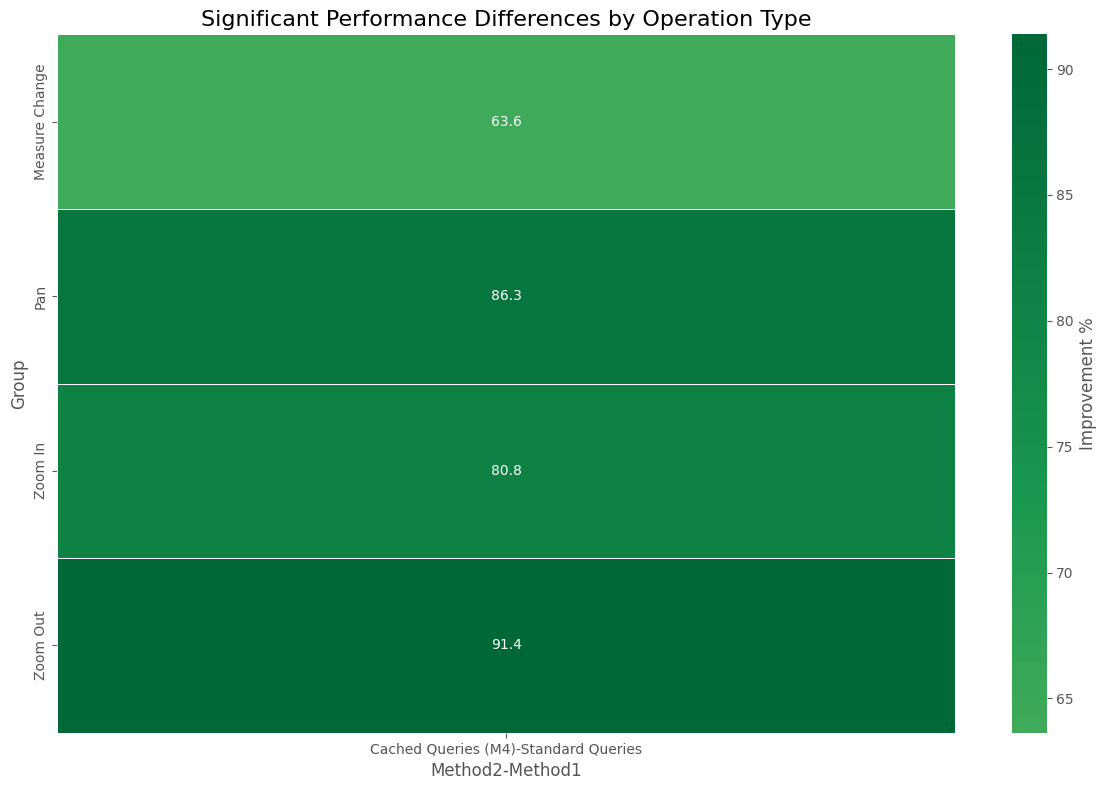

In [ ]:
if combined_results is not None and len(method_names) > 1:
    from scipy import stats
    
    # Helper function to perform ANOVA and pairwise t-tests
    def compare_performance(df, group_col='operation'):
        print(f"Statistical comparison of methods by {group_col}:")
        
        # Get unique values of the grouping column
        groups = df[group_col].unique()
        
        results = []
        for group in groups:
            # Get data for each method within this group
            group_data = {}
            for method in method_names:
                method_data = df[(df['method'] == method) & (df[group_col] == group)]['Time (sec)']
                if len(method_data) >= 2:  # Need at least 2 data points for statistical tests
                    group_data[method] = method_data
            
            # Skip if we don't have enough methods with data
            if len(group_data) < 2:
                print(f"Skipping {group}: Not enough methods with data")
                continue
            
            # If we have more than 2 methods, use ANOVA first
            if len(group_data) > 2:
                # Perform one-way ANOVA
                try:
                    f_stat, p_value = stats.f_oneway(*group_data.values())
                    print(f"\n{group}: ANOVA F={f_stat:.4f}, p={p_value:.4f} " +
                          f"({'significant' if p_value < 0.05 else 'not significant'})")
                except:
                    print(f"\n{group}: Could not perform ANOVA")
                    p_value = 1.0
            else:
                p_value = 0.049  # Skip ANOVA for 2 methods, go straight to t-test
            
            # If ANOVA is significant (or we only have 2 methods), perform pairwise t-tests
            if p_value < 0.05 or len(group_data) == 2:
                print(f"  Pairwise comparisons for {group}:")
                
                # Perform all pairwise t-tests
                for i, method_i in enumerate(group_data.keys()):
                    for j, method_j in enumerate(group_data.keys()):
                        if i < j:  # To avoid duplicate comparisons
                            try:
                                t_stat, p_value = stats.ttest_ind(
                                    group_data[method_i], 
                                    group_data[method_j], 
                                    equal_var=False
                                )
                                
                                # Calculate improvement percentage
                                mean_i = group_data[method_i].mean()
                                mean_j = group_data[method_j].mean()
                                diff_pct = ((mean_i - mean_j) / mean_i * 100) if mean_i != 0 else 0
                                
                                print(f"    {method_j} vs {method_i}: {diff_pct:.2f}% " +
                                      f"({'improvement' if diff_pct > 0 else 'regression'}), " +
                                      f"p={p_value:.4f} " +
                                      f"({'significant' if p_value < 0.05 else 'not significant'})")
                                
                                results.append({
                                    'Group': group,
                                    'Method1': method_i,
                                    'Method2': method_j,
                                    'Mean1': mean_i,
                                    'Mean2': mean_j,
                                    'Count1': len(group_data[method_i]),
                                    'Count2': len(group_data[method_j]),
                                    'Difference': mean_i - mean_j,
                                    'Improvement %': diff_pct,
                                    'p-value': p_value,
                                    'Significant': 'Yes' if p_value < 0.05 else 'No'
                                })
                            except:
                                print(f"    {method_j} vs {method_i}: Could not perform t-test")
        
        # Convert results to DataFrame and display
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values(['Group', 'p-value'])
            return results_df
        else:
            return pd.DataFrame()
    
    # Perform comparison by operation type
    print("\nStatistical comparison by operation type:")
    operation_comparison = compare_performance(combined_results, 'operation')
    
    if not operation_comparison.empty:
        display(operation_comparison)
        
        # Plot the results visually - for each operation type, show which methods are significantly better
        plt.figure(figsize=(14, len(operation_types) * 1.5))
        
        # Filter to significant differences only
        significant_diffs = operation_comparison[operation_comparison['Significant'] == 'Yes']
        
        if not significant_diffs.empty:
            # Create a heatmap-style plot
            # Group by operation and get the maximum improvement percentage for visualization
            op_method_imp = pd.pivot_table(
                significant_diffs,
                values='Improvement %',
                index='Group',
                columns=['Method2', 'Method1'],
                aggfunc='mean'
            )
            
            if not op_method_imp.empty:
                # Plot as heatmap
                plt.figure(figsize=(12, 8))
                sns.heatmap(op_method_imp, annot=True, cmap="RdYlGn", center=0,
                           linewidths=.5, fmt=".1f", cbar_kws={'label': 'Improvement %'})
                plt.title('Significant Performance Differences by Operation Type', fontsize=16)
                plt.tight_layout()
                plt.show()
            else:
                print("No significant differences to display in heatmap")
        else:
            print("No significant differences found between methods")
    else:
        print("No statistical comparison results to display")
else:
    print("Cannot perform statistical analysis without multiple datasets.")

## Summary of Method Comparisons

Let's create a summary of the performance differences between all methods.

Performance Comparison Summary
--------------------------------------------------------------------------------


,Method,Average (sec),Median (sec),Min (sec),Max (sec),Queries
0,Standard Queries,0.999442,1.025854,0.218942,1.647157,51
1,Cached Queries (M4),0.218708,0.030993,0.008262,1.813125,51



Pairwise Performance Improvements:


,Method1,Method2,Improvement %,Status
0,Standard Queries,Cached Queries (M4),78.116983,Better



Recommendations:
✅ Overall best performing method: Cached Queries (M4) (avg: 0.2187s)

Best method for each operation type:
  Initial Query: Standard Queries (avg: 1.1712s)
  Zoom In: Cached Queries (M4) (avg: 0.1853s)
  Pan: Cached Queries (M4) (avg: 0.1562s)
  Pattern Detection: Cached Queries (M4) (avg: 0.2573s)
  Measure Change: Cached Queries (M4) (avg: 0.4146s)
  Zoom Out: Cached Queries (M4) (avg: 0.0951s)


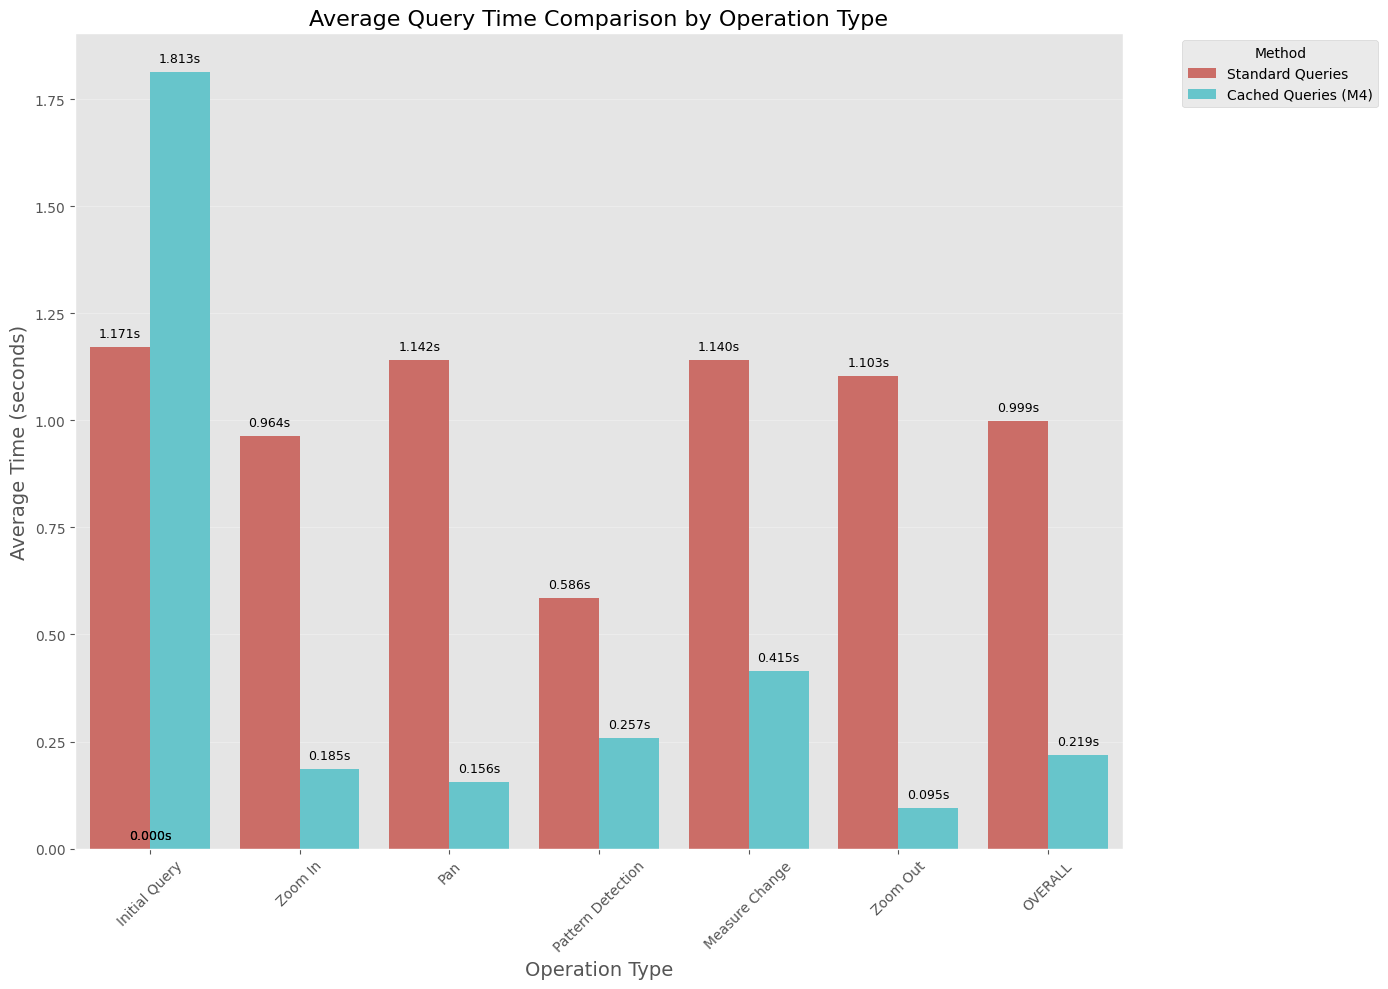

In [ ]:
if combined_results is not None and len(method_names) > 1:
    # Create a detailed summary table
    method_subsets = {name: combined_results[combined_results['method'] == name] 
                     for name in method_names}
    
    print("Performance Comparison Summary")
    print("-" * 80)
    
    # Overall metrics table
    summary_data = {
        'Method': [],
        'Average (sec)': [],
        'Median (sec)': [],
        'Min (sec)': [],
        'Max (sec)': [],
        'Queries': []
    }
    
    for method in method_names:
        subset = method_subsets[method]
        summary_data['Method'].append(method)
        summary_data['Average (sec)'].append(subset['Time (sec)'].mean())
        summary_data['Median (sec)'].append(subset['Time (sec)'].median())
        summary_data['Min (sec)'].append(subset['Time (sec)'].min())
        summary_data['Max (sec)'].append(subset['Time (sec)'].max())
        summary_data['Queries'].append(len(subset))
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    
    # Calculate pairwise improvements
    if len(method_names) > 1:
        baseline_method = method_names[0]
        baseline_avg = summary_df.loc[summary_df['Method'] == baseline_method, 'Average (sec)'].values[0]
        
        improvement_data = []
        for i, method1 in enumerate(method_names):
            for j, method2 in enumerate(method_names):
                if i < j:  # To avoid duplicate comparisons
                    m1_avg = summary_df.loc[summary_df['Method'] == method1, 'Average (sec)'].values[0]
                    m2_avg = summary_df.loc[summary_df['Method'] == method2, 'Average (sec)'].values[0]
                    imp_pct = ((m1_avg - m2_avg) / m1_avg) * 100
                    
                    improvement_data.append({
                        'Method1': method1,
                        'Method2': method2,
                        'Improvement %': imp_pct,
                        'Status': 'Better' if imp_pct > 0 else 'Worse'
                    })
        
        if improvement_data:
            print("\nPairwise Performance Improvements:")
            imp_df = pd.DataFrame(improvement_data)
            display(imp_df)
    
    # Generate recommendations based on overall performance
    print("\nRecommendations:")
    best_method_idx = summary_df['Average (sec)'].idxmin()
    best_method = summary_df.loc[best_method_idx, 'Method']
    best_method_avg = summary_df.loc[best_method_idx, 'Average (sec)']
    
    print(f"✅ Overall best performing method: {best_method} (avg: {best_method_avg:.4f}s)")
    
    # Compare methods by operation type
    print("\nBest method for each operation type:")
    
    # Calculate average time by method and operation
    op_method_avg = combined_results.groupby(['operation', 'method'])['Time (sec)'].mean().reset_index()
    
    for op_type in combined_results['operation'].unique():
        op_data = op_method_avg[op_method_avg['operation'] == op_type]
        if len(op_data) > 0:
            best_idx = op_data['Time (sec)'].idxmin()
            best_op_method = op_data.loc[best_idx, 'method']
            best_op_time = op_data.loc[best_idx, 'Time (sec)']
            print(f"  {op_type}: {best_op_method} (avg: {best_op_time:.4f}s)")
            
    # Create a summary visualization showing the best method for each operation
    summary_data = []
    for op in combined_results['operation'].unique():
        op_subset = combined_results[combined_results['operation'] == op]
        for method in method_names:
            method_subset = op_subset[op_subset['method'] == method]
            if len(method_subset) > 0:
                summary_data.append({
                    'Operation': op,
                    'Method': method,
                    'Average Time (sec)': method_subset['Time (sec)'].mean()
                })
    
    # Add Overall row
    for method in method_names:
        method_subset = combined_results[combined_results['method'] == method]
        if len(method_subset) > 0:
            summary_data.append({
                'Operation': 'OVERALL',
                'Method': method,
                'Average Time (sec)': method_subset['Time (sec)'].mean()
            })
    
    # Convert to DataFrame for plotting
    summary_plot_df = pd.DataFrame(summary_data)
    
    # Create the summary plot
    plt.figure(figsize=(max(14, len(method_names) * 3), 10))
    
    # Create the grouped bar chart
    summary_plot = sns.barplot(x='Operation', y='Average Time (sec)', hue='Method', data=summary_plot_df,
                               palette={m['name']: m['color'] for m in method_results})
    
    # Add text annotations with the actual values
    for i, p in enumerate(summary_plot.patches):
        height = p.get_height()
        if not np.isnan(height):  # Skip if height is NaN
            summary_plot.annotate(f'{height:.3f}s',
                                 (p.get_x() + p.get_width() / 2., height),
                                 ha='center', va='bottom', fontsize=9, rotation=0,
                                 xytext=(0, 5), textcoords='offset points')
    
    plt.title('Average Query Time Comparison by Operation Type', fontsize=16)
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Average Time (seconds)', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate summary without multiple datasets.")

## Conclusion

This notebook provides a comprehensive comparison between multiple query execution methods. By analyzing:

- Overall performance differences between all methods
- Performance by operation type
- Query time distributions
- Statistical significance of differences
- Performance consistency and evolution

You can make an informed decision about which method performs best for your specific use cases.

To compare different methods:
1. Edit the `METHODS` list at the top of the notebook to include all the methods you want to compare
2. For each method, provide:
   - `name`: A descriptive label for the method
   - `path`: Path to the directory containing the results
   - `database`: Type of database used (influx, postgres, etc.)
   - `table`: Name of the table or dataset
3. Run all cells to generate the comparison analysis

The notebook will automatically handle the comparison of any number of methods, generate appropriate visualizations, and provide statistical analysis to help you identify the best performing approach.